In [1]:
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties #настройка шрифта для визуализации легенды
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.manifold import TSNE

In [27]:
# Чтение файлов - тренировочного и тестового
train_df = pd.read_excel('classified_yahoo_news_train.xlsx')
test_df = pd.read_excel('classified_yahoo_news_test.xlsx')

print(f"Количество примеров в тренировочном файле: {train_df.shape[0]}")
print(f"Количество примеров в тестовом файле: {test_df.shape[0]}")

Количество примеров в тренировочном файле: 853
Количество примеров в тестовом файле: 215


In [28]:
# Кодирование категорий
label_encoder = LabelEncoder()
train_df['label_encoded'] = label_encoder.fit_transform(train_df['human_label'])

In [29]:
# Векторизация данных
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['cleaned_text'])
X_test = vectorizer.transform(test_df['cleaned_text'])
y_train = train_df['label_encoded']

In [30]:
# Обучение модели
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Dероятностей предсказаний для t-SNE
X_train_proba = model.predict_proba(X_train)

t-SNE

In [32]:
# t-SNE для визуализации
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_proba)

In [33]:
# Загрузка шрифта для японского языка
font_path = '/content/GenShinGothic-Regular.ttf'
jp_font = FontProperties(fname=font_path)

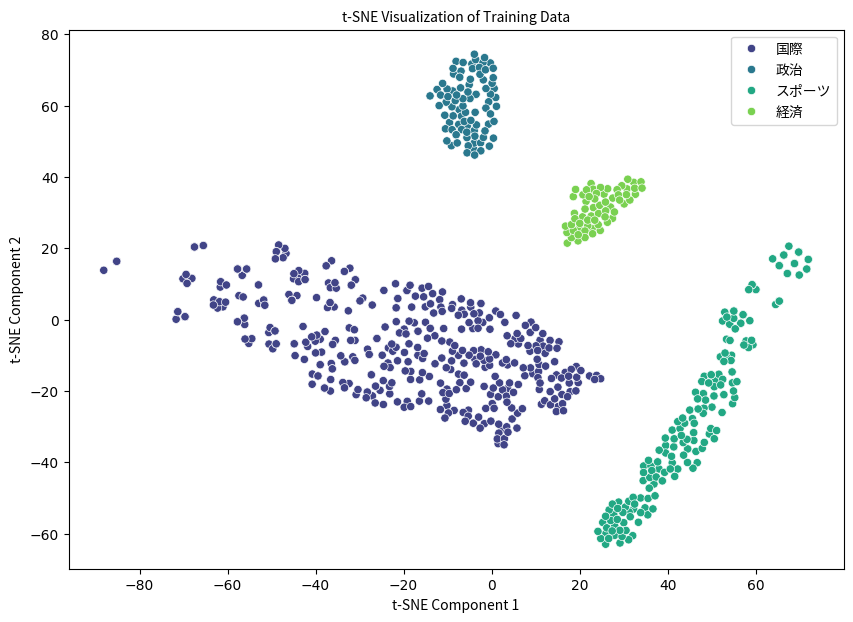

In [34]:
# Построение графика t-SNE
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_train_tsne[:, 0], y=X_train_tsne[:, 1], hue=train_df['human_label'], palette='viridis')

plt.title("t-SNE Visualization of Training Data", fontproperties=jp_font)
plt.xlabel("t-SNE Component 1", fontproperties=jp_font)
plt.ylabel("t-SNE Component 2", fontproperties=jp_font)

# Обновление шрифта легенды
legend = plt.legend(loc='best', bbox_to_anchor=(1, 1))
for text in legend.get_texts():
    text.set_font_properties(jp_font)

plt.show()

In [35]:
# Классификация на тестовом наборе
y_pred = model.predict(X_test)
test_df['label'] = label_encoder.inverse_transform(y_pred)

In [36]:
# Сохранение результатов
test_df.to_excel('classified_yahoo_news_test_predictions_RandomForest_for_t-SNE.xlsx', index=False)
print(test_df.head())

   Unnamed: 0                                               link  \
0           1  https://news.yahoo.co.jp/articles/c6a14be43198...   
1           2  https://news.yahoo.co.jp/articles/94cf6494a165...   
2           3  https://news.yahoo.co.jp/articles/5320ffcc1029...   
3           4  https://news.yahoo.co.jp/articles/f44321d169e1...   
4           5  https://news.yahoo.co.jp/articles/c941a830fdc1...   

                                               title           time  \
0         岸田首相演説に登場した首脳3人の名前　日韓・日中…去年からの変化で岸田外交を読み解き  1/29(月) 11:47   
1  トランプ氏が返り咲けば「再登板ショック」　米国の政策がひっくり返るのは確実、日米同盟破棄を突...  1/27(土) 14:04   
2  「井上尚弥を年間最優秀選手に選ばなかったらバカに見える」とフルトンも進言　BWAA会長が明か...  1/28(日) 17:56   
3                     ロシア前大統領、領土問題巡り対日強硬姿勢　クリル諸島に新兵器  1/28(日) 17:02   
4                             社説：虐殺防止命令　ガザの休戦実現へ力尽くせ  1/25(木) 16:30   

                                                text  \
0  アジアカップを戦うサッカー日本代表。その指揮官・森保一(55歳)とはいったい何者なのか？ 森...   
1  ［３０日 ロイター］ -     ２０２２年北京冬季五輪のフィギュアスケートでカミラ・ワリエ...

In [37]:
# Результат классификации на тренировочном наборе
y_train_pred = model.predict(X_train)
print("RandomForest Classification Report for Training Set:\n")
print(classification_report(y_train, y_train_pred, target_names=label_encoder.classes_, zero_division=0))

RandomForest Classification Report for Training Set:

              precision    recall  f1-score   support

        スポーツ       1.00      1.00      1.00       212
          国際       1.00      1.00      1.00       489
          政治       1.00      1.00      1.00        89
          経済       1.00      1.00      1.00        63

    accuracy                           1.00       853
   macro avg       1.00      1.00      1.00       853
weighted avg       1.00      1.00      1.00       853



In [38]:
# Загрузка файлов с полученной классификацией с помощью модели и тестового файла, в котором есть столбец с классификацией, выполненной вручную ('human_label')
predictions_df = pd.read_excel('classified_yahoo_news_test_predictions_RandomForest.xlsx')
true_labels_df = pd.read_excel('classified_yahoo_news_test_with_labels.xlsx')

In [39]:
# Объединение двух файлов на основе одного общего столбца с токенизированными текстами статей
merged_df = pd.merge(predictions_df, true_labels_df, on='cleaned_text')

In [40]:
# Кодирование категорий
label_encoder = LabelEncoder()
label_encoder.fit(merged_df['human_label'])

merged_df['true_label_encoded'] = label_encoder.transform(merged_df['human_label'])
merged_df['predicted_label_encoded'] = label_encoder.transform(merged_df['label'])

In [41]:
# Результат классификации - сравнение категорий, полученных в тестовом наборе, с присвоенными человеком
print("RandomForest Classification Report for Test Set:\n")
print(classification_report(merged_df['true_label_encoded'], merged_df['predicted_label_encoded'], target_names=label_encoder.classes_, zero_division=0))

RandomForest Classification Report for Test Set:

              precision    recall  f1-score   support

        スポーツ       0.97      0.99      0.98        78
          国際       0.65      0.98      0.78        85
          政治       1.00      0.06      0.11        33
          経済       0.83      0.26      0.40        19

    accuracy                           0.78       215
   macro avg       0.86      0.57      0.57       215
weighted avg       0.84      0.78      0.72       215

